This project's purpose is to analyze the earthquakes felt around Arad in the last 70 years and to check for any patterns

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

Going to use the USGS earthquake collection API 

In [3]:
start_time = 'now-25620days'
min_magnitude = 3
# Arad's GPS coordinates
latitude = 46.186723 
longitude = 21.305499
max_radius_km = 700

In [4]:
url = requests.get(f'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime={start_time}&minmagnitude={min_magnitude}&latitude={latitude}&longitude={longitude}&maxradiuskm={max_radius_km}')
dataset = url.json()

We need to parse the data and load it into a pandas dataframe for easier manipulation

In [5]:
dataset.keys()

dict_keys(['type', 'metadata', 'features', 'bbox'])

In [6]:
dataset = dataset['features']

In [7]:
place = []
magnitude = []
time = []
lat = []
lon = []

for feature in dataset:
    place.append(feature['properties']['place'])
    magnitude.append(feature['properties']['mag'])
    time.append(pd.to_datetime(feature['properties']['time'], unit='ms').strftime('%y/%m/%d %H:%M:%S'))
    lat.append(feature['geometry']['coordinates'][1])
    lon.append(feature['geometry']['coordinates'][0])

In [8]:
dataset_dict = {'place':place, 'magnitude':magnitude, 'time':time, 'lat':lat, 'lon':lon}

In [9]:
df = pd.DataFrame(dataset_dict)

In [10]:
df.head(-1)

,place,magnitude,time,lat,lon
0,"2 km SSW of Rakovica, Croatia",4.30,24/05/01 17:03:52,44.9763,15.6409
1,"4 km W of Rakovica, Croatia",4.40,24/05/01 03:38:47,44.9948,15.5934
2,"7 km SSE of Eşelniţa, Romania",4.20,24/04/30 05:42:05,44.6370,22.3900
3,"20 km SSW of Plužine, Montenegro",4.40,24/04/03 10:40:45,42.9884,18.7180
4,"21 km ENE of Bileća, Bosnia and Herzegovina",4.00,24/04/02 19:07:42,42.9745,18.6501
...,...,...,...,...,...
10192,"35 km ESE of Shabla, Bulgaria",5.50,56/06/30 01:50:24,43.4710,28.9590
10193,"9 km NNW of Sokolac, Bosnia and Herzegovina",5.28,56/06/28 17:42:34,44.0240,18.7770
10194,"3 km W of Ecser, Hungary",5.79,56/01/12 05:46:13,47.4430,19.2820
10195,"2 km SSE of Karyótissa, Greece",5.53,55/07/09 23:53:44,40.7460,22.3290


The next step is calculating the distance from our original coordinates (Arad).

In [11]:

def calculate_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    # Calculate the change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Calculate the distance
    distance = R * c

    return np.round(distance,2)

In [12]:
df['distance'] = df.apply(lambda row:calculate_distance(latitude,longitude, row['lat'],row['lon']) , axis = 1)

In [13]:
df.head()

,place,magnitude,time,lat,lon,distance
0,"2 km SSW of Rakovica, Croatia",4.3,24/05/01 17:03:52,44.9763,15.6409,460.81
1,"4 km W of Rakovica, Croatia",4.4,24/05/01 03:38:47,44.9948,15.5934,463.69
2,"7 km SSE of Eşelniţa, Romania",4.2,24/04/30 05:42:05,44.6370,22.3900,191.99
3,"20 km SSW of Plužine, Montenegro",4.4,24/04/03 10:40:45,42.9884,18.7180,410.39
4,"21 km ENE of Bileća, Bosnia and Herzegovina",4.0,24/04/02 19:07:42,42.9745,18.6501,414.44


Now let's convert the time into a datetime pandas object

In [14]:
def parse_data(x):
    x = x.split(' ')[0]
    year, month, date = x.split('/')

    if year >='36':
        year = '19' + year
    else:
        year = '20' + year
    return pd.to_datetime(f'{year}-{month}-{date}')


In [15]:
df['time'] = df['time'].apply(lambda x:parse_data(x))

In [16]:
df.head()

,place,magnitude,time,lat,lon,distance
0,"2 km SSW of Rakovica, Croatia",4.3,2024-05-01,44.9763,15.6409,460.81
1,"4 km W of Rakovica, Croatia",4.4,2024-05-01,44.9948,15.5934,463.69
2,"7 km SSE of Eşelniţa, Romania",4.2,2024-04-30,44.6370,22.3900,191.99
3,"20 km SSW of Plužine, Montenegro",4.4,2024-04-03,42.9884,18.7180,410.39
4,"21 km ENE of Bileća, Bosnia and Herzegovina",4.0,2024-04-02,42.9745,18.6501,414.44


In [17]:
df.dtypes

place                object
magnitude           float64
time         datetime64[ns]
lat                 float64
lon                 float64
distance            float64
dtype: object

We need a way to sort the earthquakes by their approximated impact on Arad. While magnitude is not dirrectly correlated to the distance, it is impossible to find an exact formula for what we need.
What we know, though, is that an earthquake with a higher magnitude and a shorter distance from Arad is felt the most. Using this logic, it is easy to deduce the ratio of MAGNITUDE/DISTANCE. However, the magnitude on the richter scale scales exponentially. This is not an exact number, but I tweaked with the power that we raise it until on the top earthquakes list we could find the earthquakes that locals remember experiencing in this city. The notable earthquakes that we were looking for are: the 2 earthquakes in 2023 that happened in Arad county (which I have personally experienced), the biggest and most destructive earthquake in Romania (1977, near Bucharest) and the 1991 Ciacova earthquake.
Knowing these 4 earthquakes that people said they felt while living in Arad, we can tweak with the power we raise the magnitude by to get an approximation of the correlation between magnitude and distance. This is not a highly accurrate formula, because a high magnitude does not necessarily mean a large radius, but due to the lack of data, this is the closest formula I could get to retrieve a list of the most "felt" earthquakes in Arad.

In [18]:
df['ratio'] = df.apply(lambda x:(x['magnitude']**6.5)/x['distance'], axis=1)

In [19]:
df.sort_values('ratio', ascending=False)[:10][['place','time','magnitude', 'distance', 'ratio']]

,place,time,magnitude,distance,ratio
10090,"4 km S of M?n??tur, Romania",1974-04-17,5.60,27.04,2699.078329
52,"6 km SW of Frumu?eni, Romania",2023-06-06,4.70,15.47,1510.587070
9869,"2 km N of Spulber, Romania",1977-03-04,7.50,423.98,1149.616111
8182,"7 km NNE of Ca?oca, Romania",1986-08-30,7.20,394.35,947.936796
6649,"1 km SW of Ciacova, Romania",1991-12-02,5.50,77.99,832.374106
10184,"6 km ESE of Cenei, Romania",1959-05-27,5.28,60.09,828.549181
53,"2 km S of Fântânele, Romania",2023-05-22,4.10,11.70,822.070771
6814,"2 km S of Livezile, Romania",1991-07-12,5.60,93.49,780.651171
7186,"5 km W of Nistore?ti, Romania",1990-05-30,7.00,415.81,748.587085
9615,"6 km E of Stari Bar, Montenegro",1979-04-15,6.90,484.61,584.960739


Now let's get a closer look to the earthquakes that had their epicenters close to Arad

In [20]:
df_close = df[df['distance']<=100].copy(deep=True)
df_close.head()

,place,magnitude,time,lat,lon,distance,ratio
37,"6 km SE of Szarvas, Hungary",3.5,2023-08-20,46.8276,20.6207,88.46,38.877234
38,"10 km E of Szarvas, Hungary",3.4,2023-08-19,46.8563,20.6839,88.35,32.240844
39,"10 km ESE of Szarvas, Hungary",3.7,2023-08-19,46.8358,20.6764,86.76,56.884201
40,"10 km ESE of Szarvas, Hungary",3.6,2023-08-19,46.8446,20.6875,87.11,47.413088
52,"6 km SW of Frumu?eni, Romania",4.7,2023-06-06,46.0645,21.4014,15.47,1510.587070


I want to see a graph of the number of earthquakes that happened each year

Let's add a year column and group the values by that column

In [21]:
df_close['year'] = df_close['time'].dt.year
df_close.head()

,place,magnitude,time,lat,lon,distance,ratio,year
37,"6 km SE of Szarvas, Hungary",3.5,2023-08-20,46.8276,20.6207,88.46,38.877234,2023
38,"10 km E of Szarvas, Hungary",3.4,2023-08-19,46.8563,20.6839,88.35,32.240844,2023
39,"10 km ESE of Szarvas, Hungary",3.7,2023-08-19,46.8358,20.6764,86.76,56.884201,2023
40,"10 km ESE of Szarvas, Hungary",3.6,2023-08-19,46.8446,20.6875,87.11,47.413088,2023
52,"6 km SW of Frumu?eni, Romania",4.7,2023-06-06,46.0645,21.4014,15.47,1510.587070,2023


In [22]:
eq_per_yr = df_close.value_counts('year')

for yr in range(eq_per_yr.index.min(), eq_per_yr.index.max()+1):
    if yr not in eq_per_yr.index:
        eq_per_yr[yr]=0
eq_per_yr = eq_per_yr.sort_index()
eq_per_yr

year
1959    1
1960    0
1961    0
1962    0
1963    0
       ..
2019    0
2020    0
2021    0
2022    0
2023    6
Name: count, Length: 65, dtype: int64

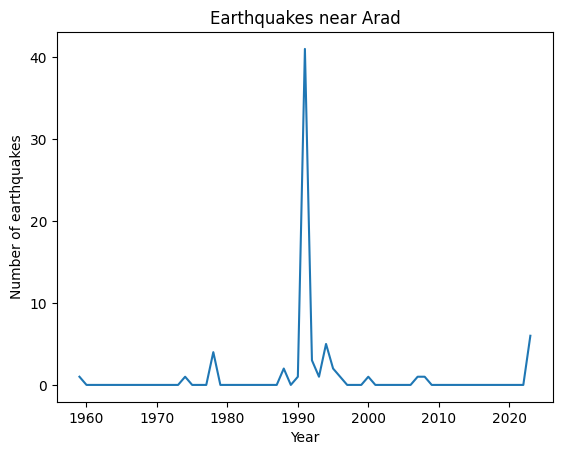

In [23]:
plt.plot(eq_per_yr.index, eq_per_yr.values)
plt.xlabel('Year')
plt.ylabel('Number of earthquakes')
plt.title('Earthquakes near Arad')
plt.show()

We can see that an extremely high amount of earthquakes occurred near Arad in 1991.

In [24]:
eq_1991 = df_close[df_close['year']==1991].sort_values('time').copy(deep=True)
eq_1991.head(20)

,place,magnitude,time,lat,lon,distance,ratio,year
6814,"2 km S of Livezile, Romania",5.6,1991-07-12,45.364,21.057,93.49,780.651171,1991
6813,"3 km SE of Ghilad, Romania",4.1,1991-07-12,45.446,21.167,83.06,115.798555,1991
6811,"3 km S of Banloc, Romania",3.5,1991-07-13,45.358,21.137,93.07,36.951543,1991
6812,"2 km NE of Deta, Romania",4.0,1991-07-13,45.403,21.241,87.29,93.848093,1991
6810,Romania,3.3,1991-07-14,45.404,21.076,88.83,26.410763,1991
6808,"3 km S of Ghilad, Romania",4.1,1991-07-14,45.431,21.129,85.14,112.969556,1991
6805,"4 km SSW of Banloc, Romania",4.4,1991-07-19,45.344,21.123,94.77,160.609606,1991
6804,"7 km ENE of Stari Lec, Serbia",5.1,1991-07-19,45.312,21.053,99.22,400.504059,1991
6802,"1 km SE of Deta, Romania",3.8,1991-07-20,45.375,21.240,90.40,64.926942,1991
6801,"5 km SSW of Banloc, Romania",4.1,1991-07-20,45.346,21.108,94.73,101.533073,1991


In [25]:
eq_1991_dates = eq_1991.value_counts('time').sort_index()


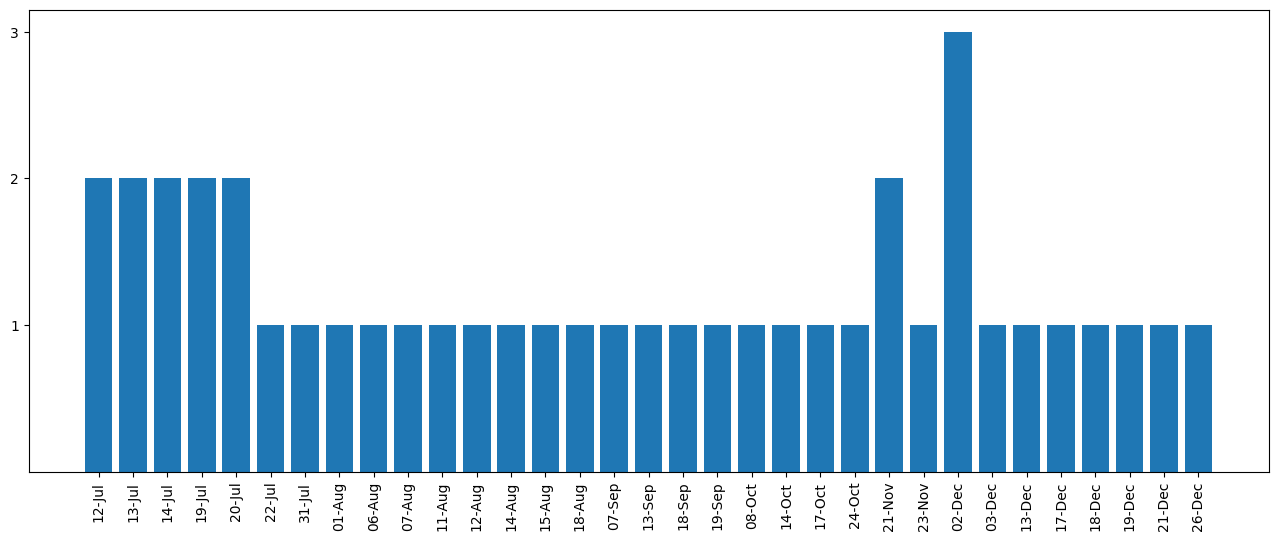

In [26]:
plt.figure(figsize=(16, 6))
xlabels = [date.strftime('%d-%b') for date in eq_1991_dates.index]
bars = plt.bar(xlabels, eq_1991_dates.values)  
plt.xticks(xlabels, rotation=90)

plt.yticks(range(1,4), range(1,4))
# plt.grid()
plt.show()


The dates are spread apart, so the earthquakes are very unlikely to be duplicates, considering the magnitudes and locations are different too. 

In [27]:
df_close[df_close['year']==1992].sort_values('time')

,place,magnitude,time,lat,lon,distance,ratio,year
6582,"5 km ESE of Bogda, Romania",4.6,1992-03-02,45.952,21.630,36.16,561.949752,1992
6342,"3 km WNW of Giulv?z, Romania",4.6,1992-12-19,45.561,20.950,74.82,271.586515,1992
6340,"3 km E of Giulv?z, Romania",3.6,1992-12-23,45.555,21.031,73.39,56.276796,1992


It is interesting that they only occured on the second half of the year, and no following earthquakes in the beginning of the next year.

Let's visualize the locations of the earthquakes

In [28]:
import plotly.express as px

In [29]:
eq_1991['date'] = eq_1991['time'].apply(lambda x: x.strftime('%d-%b'))

In [30]:
eq_1991.head()

,place,magnitude,time,lat,lon,distance,ratio,year,date
6814,"2 km S of Livezile, Romania",5.6,1991-07-12,45.364,21.057,93.49,780.651171,1991,12-Jul
6813,"3 km SE of Ghilad, Romania",4.1,1991-07-12,45.446,21.167,83.06,115.798555,1991,12-Jul
6811,"3 km S of Banloc, Romania",3.5,1991-07-13,45.358,21.137,93.07,36.951543,1991,13-Jul
6812,"2 km NE of Deta, Romania",4.0,1991-07-13,45.403,21.241,87.29,93.848093,1991,13-Jul
6810,Romania,3.3,1991-07-14,45.404,21.076,88.83,26.410763,1991,14-Jul


In [31]:


color_scale = [(0, 'yellow'), (1,'red')]

fig = px.scatter_mapbox(eq_1991, 
                        lat="lat", 
                        lon="lon",
                        hover_name="date", 
                        hover_data=["date", "magnitude"],
                        color="magnitude",
                        color_continuous_scale=color_scale,
                        size="magnitude",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

[note: the interactive map of the earthquakes is not visible on the github page]

We can see 2 clusters of earthquakes:
-the first cluster, which happened by the end of the year, located to the NE of Timisoara
-the second cluster, which happened all throughout the second half of the year, located near Ciacova. Majority of the earthquakes that happened in '91 belong to this cluster. This would be worth investigating further, however, I do not have enough knowledge in seismology to do so.

Conclusions:

We have seen the most "impactful" and noticeable earthquakes in Arad.
We have also noticed a cluster of earthquakes by the second half of the year 1991.
It is unlikely to be a dataset fault or an error, due to the different times, locations and magnitudes of the recorded earthquakes.
The cluster in 1991 near Ciacova is worth analyzing further.